<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/ETA-Prediction/TransitLK_ETA_COO_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TransitLK ETA Prediction using GPS Coordinates for a Reinfircement Learning Model**

## **Setup & Data Loading**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import warnings
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
warnings.filterwarnings('ignore')

#upload multiple CSV files
from google.colab import files
print("Upload your GPS tracking CSV files:")
uploaded = files.upload()

#bus stops coordinates
STOPS_RATMALANA_TO_BAMBALAPITIYA = {
    'Golumadama Junction': (6.810710433346013, 79.88234748854951),
    'Belekkade Junction': (6.8146479033245635, 79.8786692065216),
    'Vijitha Halt': (6.817364226961181, 79.87515452515784),
    'Maliban Junction': (6.8194577635422124, 79.87356021650437),
    'Lalanka Ratmalana': (6.823173544815911, 79.87089474281404),
    'Mount Lavinia Police': (6.825433076668215, 79.8697448676328),
    'Hena Road': (6.827617966613862, 79.86882974754288),
    'Templers Road': (6.829886421994827, 79.86792953598227),
    'Mount Lavinia': (6.833045356006737, 79.8672686549206),
    'Mount Lavinia Court': (6.837786821228232, 79.86744519979364),
    'Hotel Road': (6.841953093983693, 79.86681483570858),
    'Cemetery Odeon': (6.844687001271335, 79.86624066452525),
    'Dehiwala Arpico': (6.848879893559448, 79.86590953737266),
    'Dehiwala Junction': (6.851828715024246, 79.86582328306689),
    'Holy Family Convent': (6.857468319954902, 79.86482602887749),
    'Dehiwala Municipal Council': (6.860582711248441, 79.8641225998664),
    'Roxy Gardens': (6.865106324084456, 79.86314173387338),
    'Wellawatte Arpico': (6.8682853649914275, 79.862428435965),
    'Wellawatte Junction': (6.874023870852789, 79.86131857372347),
    'Wellawatte Mosque': (6.876563055661567, 79.86056854446126),
    'St Peters College Bambalapitiya': (6.881175353490238, 79.8592262906708),
    'Bambalapitiya Flats': (6.883890855756892, 79.85844491547076),
    'Vishaka Halt': (6.889274548319365, 79.85685837407006),
    'Bambalapitiya Junction': (6.893351808564476, 79.855543129179)
}

STOPS_BAMBALAPITIYA_TO_RATMALANA = {
    'Bambalapitiya Junction': (6.89421833503331, 79.85743403491827),
    'Vishaka Halt': (6.89173101441345, 79.8584053406695),
    'ICBT Halt': (6.889393164214705, 79.8590995087839),
    'Hindu College Halt': (6.884334511228433, 79.86070021206346),
    'St Peters College Bambalapitiya': (6.881086292650558, 79.8617310945956),
    'Savoy Cinema': (6.878835594116245, 79.86009414378748),
    'Wellawatte Mosque': (6.8771052996116175, 79.86059155256277),
    'Wellawatte Junction': (6.872737657676879, 79.86178650617411),
    'Mangala Halt': (6.8692420950487625, 79.86241265699829),
    'Bodhirukkarama Road': (6.867136549076562, 79.86287715406156),
    'Sampath Bank': (6.863900146136533, 79.86355735448383),
    'Dehiwala Municipal Council': (6.860955823546713, 79.86419762016793),
    'Waidya Road': (6.857253482269844, 79.86503874198182),
    'Dehiwala Junction': (6.850799164629326, 79.86604776762717),
    'Dehiwala Arpico': (6.846449249637398, 79.86620254157684),
    'Cemetery Odeon Halt': (6.844567214152192, 79.86638914094856),
    'Hotel Road': (6.840839172206239, 79.86731964153903),
    'Mount Lavinia Court': (6.838936668749608, 79.86760275370851),
    'Mount Lavinia': (6.835397391774186, 79.86747652243051),
    'Templers Road': (6.8299294447021595, 79.86810987892238),
    'Hena Road': (6.8281855997807135, 79.86877146177072),
    'Mount Lavinia Police': (6.825727535178407, 79.86978457126469),
    'Maliban Junction': (6.82127469622858, 79.8724412976936),
    'Vijitha Halt': (6.817455615075621, 79.87531600011668),
    'Belekkade Junction': (6.815648653029313, 79.87772014801567),
    'Ratmalana Airport': (6.812204148716779, 79.88141611315496),
    'Golumadama Junction': (6.80942743800072, 79.88337382556504)
}

#key stops for model focus (Maliban Junction to Wellawatte Junction)
KEY_STOPS_R2B = ['Maliban Junction', 'Lalanka Ratmalana', 'Mount Lavinia Police', 'Hena Road',
                 'Templers Road', 'Mount Lavinia', 'Mount Lavinia Court', 'Hotel Road',
                 'Cemetery Odeon', 'Dehiwala Arpico', 'Dehiwala Junction', 'Holy Family Convent',
                 'Dehiwala Municipal Council', 'Roxy Gardens', 'Wellawatte Arpico', 'Wellawatte Junction']

KEY_STOPS_B2R = ['Wellawatte Junction', 'Mangala Halt', 'Bodhirukkarama Road', 'Sampath Bank',
                 'Dehiwala Municipal Council', 'Waidya Road', 'Dehiwala Junction', 'Dehiwala Arpico',
                 'Cemetery Odeon Halt', 'Hotel Road', 'Mount Lavinia Court', 'Mount Lavinia',
                 'Templers Road', 'Hena Road', 'Mount Lavinia Police', 'Maliban Junction']

DETECTION_RADIUS = 50  #meters

print(f"Loaded {len(STOPS_RATMALANA_TO_BAMBALAPITIYA)} stops for Ratmalana -> Bambalapitiya")
print(f"Loaded {len(STOPS_BAMBALAPITIYA_TO_RATMALANA)} stops for Bambalapitiya -> Ratmalana")

Upload your GPS tracking CSV files:


Saving TransitLK_1770631761503.csv to TransitLK_1770631761503.csv
Saving TransitLK_1770864092506.csv to TransitLK_1770864092506.csv
Saving TransitLK_1770978313303.csv to TransitLK_1770978313303.csv
Saving TransitLK_1771063695743.csv to TransitLK_1771063695743.csv
Saving TransitLK_1770784513707.csv to TransitLK_1770784513707.csv
Saving TransitLK_1771071149930.csv to TransitLK_1771071149930.csv
Saving TransitLK_1770691351798.csv to TransitLK_1770691351798.csv
Saving TransitLK_1771061681000.csv to TransitLK_1771061681000.csv
Saving TransitLK_1771000462120.csv to TransitLK_1771000462120.csv
Saving TransitLK_1770114296072.csv to TransitLK_1770114296072.csv
Saving TransitLK_1768712545951.csv to TransitLK_1768712545951.csv
Saving TransitLK_1768705904623.csv to TransitLK_1768705904623.csv
Saving TransitLK_1769482275640.csv to TransitLK_1769482275640.csv
Saving TransitLK_1770085942785.csv to TransitLK_1770085942785.csv
Saving TransitLK_1769141577728.csv to TransitLK_1769141577728.csv
Saving Tra

## **Helper Functions**



In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points on earth (in meters)
    """
    R = 6371000  #earth radius in meters

    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    distance = R * c
    return distance

def detect_route_direction(df):
    """
    Detect if route is Ratmalana->Bambalapitiya or Bambalapitiya->Ratmalana
    Based on general movement direction (latitude trend)
    """
    #calculate average latitude change
    lat_start = df['lat'].iloc[:10].mean()
    lat_end = df['lat'].iloc[-10:].mean()

    if lat_end > lat_start:
        return 'R2B', STOPS_RATMALANA_TO_BAMBALAPITIYA, KEY_STOPS_R2B
    else:
        return 'B2R', STOPS_BAMBALAPITIYA_TO_RATMALANA, KEY_STOPS_B2R

def find_nearest_stop(lat, lon, stops_dict, key_stops, max_distance=DETECTION_RADIUS):
    """
    Find the nearest stop within detection radius
    Returns (stop_name, distance) or (None, None)
    """
    min_distance = float('inf')
    nearest_stop = None

    for stop_name, (stop_lat, stop_lon) in stops_dict.items():
        if stop_name not in key_stops:
            continue

        distance = haversine_distance(lat, lon, stop_lat, stop_lon)

        if distance < min_distance and distance <= max_distance:
            min_distance = distance
            nearest_stop = stop_name

    return nearest_stop, min_distance if nearest_stop else None


##**Data Loading and Labeling**

In [3]:
print("Loading and Processing GPS Data")


all_data = []

for filename in uploaded.keys():
    print(f"\nProcessing: {filename}")

    #load CSV
    df = pd.read_csv(filename)
    print(f"  Loaded {len(df)} GPS points")

    #cetect route direction
    direction, stops_dict, key_stops = detect_route_direction(df)
    print(f"  Detected route: {direction}")

    #add stop labels
    df['stop_name'] = None
    df['distance_to_stop'] = None
    df['at_stop'] = 0  #binary label: 1 if at stop, 0 otherwise

    stop_detections = {}

    for idx, row in df.iterrows():
        stop_name, distance = find_nearest_stop(row['lat'], row['lng'], stops_dict, key_stops)

        if stop_name:
            df.at[idx, 'stop_name'] = stop_name
            df.at[idx, 'distance_to_stop'] = distance
            df.at[idx, 'at_stop'] = 1

            if stop_name not in stop_detections:
                stop_detections[stop_name] = 0
            stop_detections[stop_name] += 1

    print(f"  Detected {len(stop_detections)} stops:")
    for stop, count in sorted(stop_detections.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"    - {stop}: {count} points")

    all_data.append(df)

#combine all data
combined_df = pd.concat(all_data, ignore_index=True)
print(f"\nTotal combined data: {len(combined_df)} GPS points")
print(f"Points at stops: {combined_df['at_stop'].sum()}")
print(f"Points not at stops: {len(combined_df) - combined_df['at_stop'].sum()}")

Loading and Processing GPS Data

Processing: TransitLK_1770631761503.csv
  Loaded 1776 GPS points
  Detected route: R2B
  Detected 16 stops:
    - Mount Lavinia: 110 points
    - Wellawatte Junction: 77 points
    - Wellawatte Arpico: 48 points
    - Dehiwala Junction: 29 points
    - Maliban Junction: 25 points

Processing: TransitLK_1770864092506.csv
  Loaded 1879 GPS points
  Detected route: R2B
  Detected 16 stops:
    - Templers Road: 73 points
    - Cemetery Odeon: 45 points
    - Maliban Junction: 42 points
    - Holy Family Convent: 38 points
    - Mount Lavinia: 36 points

Processing: TransitLK_1770978313303.csv
  Loaded 1576 GPS points
  Detected route: R2B
  Detected 16 stops:
    - Templers Road: 68 points
    - Wellawatte Arpico: 51 points
    - Wellawatte Junction: 49 points
    - Mount Lavinia: 33 points
    - Dehiwala Junction: 33 points

Processing: TransitLK_1771063695743.csv
  Loaded 1515 GPS points
  Detected route: R2B
  Detected 0 stops:

Processing: TransitLK_177

## **Exploratory Data Analysis (EDA)**


Exploratory Data Analysis

1. Dataset Info:
Shape: (33178, 16)
Columns: ['timestamp', 'lat', 'lng', 'altitude', 'speed_mps', 'accuracy', 'satellites', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'stop_name', 'distance_to_stop', 'at_stop']

2. Missing Values:
timestamp               0
lat                     0
lng                     0
altitude                0
speed_mps               0
accuracy                0
satellites              0
ax                      0
ay                      0
az                      0
gx                      0
gy                      0
gz                      0
stop_name           23610
distance_to_stop    23610
at_stop                 0
dtype: int64

3. Class Distribution (At Stop vs Not At Stop):
at_stop
0    23610
1     9568
Name: count, dtype: int64

Stop detection rate: 28.84%


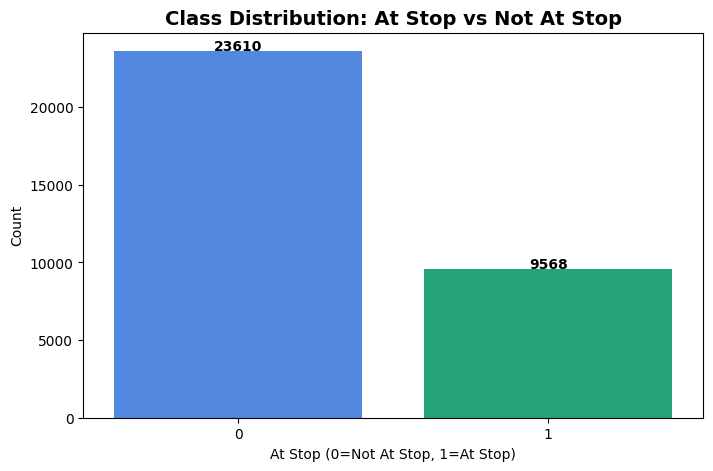


4. GPS and Sensor Statistics:
                lat           lng     speed_mps      accuracy            ax  \
count  33178.000000  33178.000000  33178.000000  33178.000000  33178.000000   
mean       6.854351     79.864994      3.958784      9.174813      0.511154   
std        0.025419      0.006019      3.263979      3.192451      2.427854   
min        6.809124     79.842022      0.000000      3.010000    -11.471491   
25%        6.834618     79.862099      0.770500      9.935000     -0.914656   
50%        6.851789     79.865856      3.622000      9.954000      0.364905   
75%        6.870314     79.867404      6.512000     10.238000      1.869916   
max        6.934922     79.883412     15.150000    302.885010     13.655839   

                 ay            az            gx            gy            gz  
count  33178.000000  33178.000000  33178.000000  33178.000000  33178.000000  
mean       0.680643      2.937586     -0.022515      0.025050     -0.091218  
std        3.520234    

In [4]:
print("\n" + "="*60)
print("Exploratory Data Analysis")
print("="*60)

print("\n1. Dataset Info:")
print(f"Shape: {combined_df.shape}")
print(f"Columns: {list(combined_df.columns)}")

print("\n2. Missing Values:")
print(combined_df.isnull().sum())

print("\n3. Class Distribution (At Stop vs Not At Stop):")
stop_counts = combined_df['at_stop'].value_counts()
print(stop_counts)
print(f"\nStop detection rate: {stop_counts.get(1, 0)/len(combined_df):.2%}")

#visualize class distribution
plt.figure(figsize=(8,5))
sns.barplot(x=stop_counts.index, y=stop_counts.values, palette=['#3b82f6','#10b981'])
plt.title('Class Distribution: At Stop vs Not At Stop', fontsize=14, fontweight='bold')
plt.xlabel('At Stop (0=Not At Stop, 1=At Stop)')
plt.ylabel('Count')
for i, v in enumerate(stop_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.show()

print("\n4. GPS and Sensor Statistics:")
numeric_cols = ['lat', 'lng', 'speed_mps', 'accuracy', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']
print(combined_df[numeric_cols].describe())

## **Data Preprocessing**

In [5]:
print("Data Cleaning & Preprocessing")

df_clean = combined_df.copy()

print(f"\n1. Dataset shape: {df_clean.shape}")

#handle missing values
print("\n2. Handling missing values...")
missing_before = df_clean.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

#fill numeric columns with median
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

missing_after = df_clean.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

#separate features and target
print("\n3. Separating features and target...")

#core mobile sensor features
MOBILE_FEATURES = [
    'lat', 'lng', 'speed_mps', 'accuracy',
    'ax', 'ay', 'az', 'gx', 'gy', 'gz'
]

#remove rows with missing target
df_clean = df_clean.dropna(subset=['at_stop'])

X = df_clean[MOBILE_FEATURES]
y = df_clean['at_stop']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {MOBILE_FEATURES}")


Data Cleaning & Preprocessing

1. Dataset shape: (33178, 16)

2. Handling missing values...
Missing values before: 47220
Missing values after: 47220

3. Separating features and target...
Feature matrix shape: (33178, 10)
Target vector shape: (33178,)
Features: ['lat', 'lng', 'speed_mps', 'accuracy', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']


##**Feature Engineering**

In [6]:
print("Feature Engineering")

X_engineered = X.copy()

#acceleration magnitude (total G force)
X_engineered['accel_magnitude'] = np.sqrt(
    X_engineered['ax']**2 + X_engineered['ay']**2 + X_engineered['az']**2
)

#gyroscope magnitude (total rotation)
X_engineered['gyro_magnitude'] = np.sqrt(
    X_engineered['gx']**2 + X_engineered['gy']**2 + X_engineered['gz']**2
)
#speed features
X_engineered['speed_kmh'] = X_engineered['speed_mps'] * 3.6  # Convert to km/h
X_engineered['is_slow'] = (X_engineered['speed_mps'] < 2.0).astype(int)  # Speed < 2 m/s
X_engineered['is_stopped'] = (X_engineered['speed_mps'] < 0.5).astype(int)  # Nearly stopped

#movement smoothness (jerk approximation using acceleration change)
X_engineered['accel_jerk'] = X_engineered['accel_magnitude'].diff().abs().fillna(0)

#GPS accuracy indicator
X_engineered['high_accuracy'] = (X_engineered['accuracy'] < 10).astype(int)

print("\nEngineered features:")
print("1. accel_magnitude - Total acceleration force")
print("2. gyro_magnitude - Total rotation force")
print("3. speed_kmh - Speed in km/h")
print("4. is_slow - Binary: speed < 2 m/s")
print("5. is_stopped - Binary: speed < 0.5 m/s")
print("6. accel_jerk - Rate of acceleration change")
print("7. high_accuracy - Binary: GPS accuracy < 10m")

#final feature set
FINAL_FEATURES = MOBILE_FEATURES + [
    'accel_magnitude', 'gyro_magnitude', 'speed_kmh',
    'is_slow', 'is_stopped', 'accel_jerk', 'high_accuracy'
]

X_final = X_engineered[FINAL_FEATURES]

print(f"\nFinal feature matrix: {X_final.shape}")
print(f"Total features: {len(FINAL_FEATURES)}")

Feature Engineering

Engineered features:
1. accel_magnitude - Total acceleration force
2. gyro_magnitude - Total rotation force
3. speed_kmh - Speed in km/h
4. is_slow - Binary: speed < 2 m/s
5. is_stopped - Binary: speed < 0.5 m/s
6. accel_jerk - Rate of acceleration change
7. high_accuracy - Binary: GPS accuracy < 10m

Final feature matrix: (33178, 17)
Total features: 17


##**Handle Class Imbalance**

Balancing Class Distribution

Before balancing:
at_stop
0    23610
1     9568
Name: count, dtype: int64
Imbalance ratio: 2.47:1

After SMOTE balancing:
at_stop
0    23610
1    23610
Name: count, dtype: int64
New shape: (47220, 17)


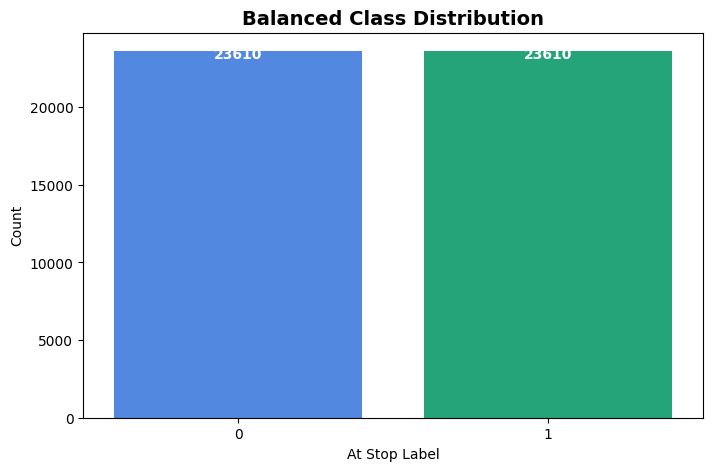

In [7]:
print("Balancing Class Distribution")

print(f"\nBefore balancing:")
print(y.value_counts())
print(f"Imbalance ratio: {y.value_counts()[0] / y.value_counts().get(1, 1):.2f}:1")

#check if we have enough samples for SMOTE
if y.sum() >= 5:  # Need at least 5 positive samples
    #use SMOTE to balance the dataset
    smote = SMOTE(random_state=42, k_neighbors=min(3, y.sum()-1))
    X_balanced, y_balanced = smote.fit_resample(X_final, y)

    print(f"\nAfter SMOTE balancing:")
    print(pd.Series(y_balanced).value_counts())
    print(f"New shape: {X_balanced.shape}")

    #visualize balanced distribution
    plt.figure(figsize=(8,5))
    balanced_counts = pd.Series(y_balanced).value_counts()
    sns.barplot(x=balanced_counts.index, y=balanced_counts.values, palette=['#3b82f6','#10b981'])
    plt.title('Balanced Class Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('At Stop Label')
    plt.ylabel('Count')
    for i, v in enumerate(balanced_counts.values):
        plt.text(i, v - 500, str(v), ha='center', fontweight='bold', color='white')
    plt.show()
else:
    print(f"\nWarning: Not enough positive samples ({y.sum()}) for SMOTE. Using original data.")
    X_balanced = X_final
    y_balanced = y

##**Train Model**


In [8]:
print("Training XGBoost Model")

print(f"\nXGBoost Version: {xgb.__version__}")

#split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

#initialize XGBoost with optimized parameters for stop detection
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

print("\nTraining in progress...")

#train the model
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

print("\nTraining complete!")


Training XGBoost Model

XGBoost Version: 3.1.3
Train set: 37776 samples
Test set: 9444 samples

Training in progress...
[0]	validation_0-logloss:0.66073	validation_1-logloss:0.66070
[1]	validation_0-logloss:0.63384	validation_1-logloss:0.63388
[2]	validation_0-logloss:0.61185	validation_1-logloss:0.61208
[3]	validation_0-logloss:0.59227	validation_1-logloss:0.59235
[4]	validation_0-logloss:0.57638	validation_1-logloss:0.57663
[5]	validation_0-logloss:0.56282	validation_1-logloss:0.56307
[6]	validation_0-logloss:0.54936	validation_1-logloss:0.54979
[7]	validation_0-logloss:0.53757	validation_1-logloss:0.53800
[8]	validation_0-logloss:0.52709	validation_1-logloss:0.52767
[9]	validation_0-logloss:0.51774	validation_1-logloss:0.51854
[10]	validation_0-logloss:0.50960	validation_1-logloss:0.51016
[11]	validation_0-logloss:0.49894	validation_1-logloss:0.49908
[12]	validation_0-logloss:0.49231	validation_1-logloss:0.49260
[13]	validation_0-logloss:0.48627	validation_1-logloss:0.48675
[14]	val

##**Model Evaluation & Confusion Matrix**

Model Evaluation

Test Accuracy: 92.41%
Precision: 92.60%
Recall (Sensitivity): 92.19%
F1-Score: 92.39%

Classification Report:
              precision    recall  f1-score   support

 Not At Stop       0.92      0.93      0.92      4722
     At Stop       0.93      0.92      0.92      4722

    accuracy                           0.92      9444
   macro avg       0.92      0.92      0.92      9444
weighted avg       0.92      0.92      0.92      9444


Confusion Matrix:
[[4374  348]
 [ 369 4353]]

Additional Metrics:
Sensitivity (True Positive Rate): 92.19%
Specificity (True Negative Rate): 92.63%
Positive Predictive Value (PPV): 92.60%
Negative Predictive Value (NPV): 92.22%


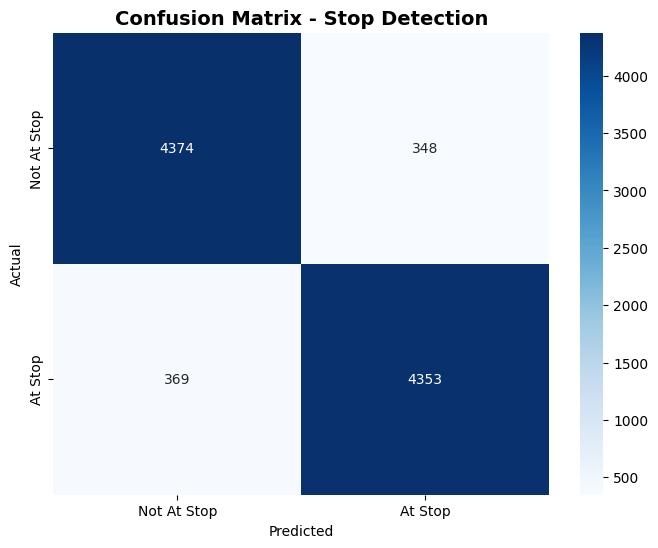

In [9]:
print("Model Evaluation")

#make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

#calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"\nTest Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall (Sensitivity): {recall:.2%}")
print(f"F1-Score: {f1:.2%}")

#detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not At Stop', 'At Stop']))

#confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

#calculate additional metrics
tn, fp, fn, tp = cm.ravel()

#sensitivity (Recall/True Positive Rate)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

#specificity (True Negative Rate)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

#Positive Predictive Value (PPV/Precision)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0

#Negative Predictive Value (NPV)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\n{'='*60}")
print("Additional Metrics:")
print(f"{'='*60}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.2%}")
print(f"Specificity (True Negative Rate): {specificity:.2%}")
print(f"Positive Predictive Value (PPV): {ppv:.2%}")
print(f"Negative Predictive Value (NPV): {npv:.2%}")

#visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not At Stop', 'At Stop'],
            yticklabels=['Not At Stop', 'At Stop'])
plt.title('Confusion Matrix - Stop Detection', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



##**PPV and NPV Analysis Plots**

PPV and NPV Analysis


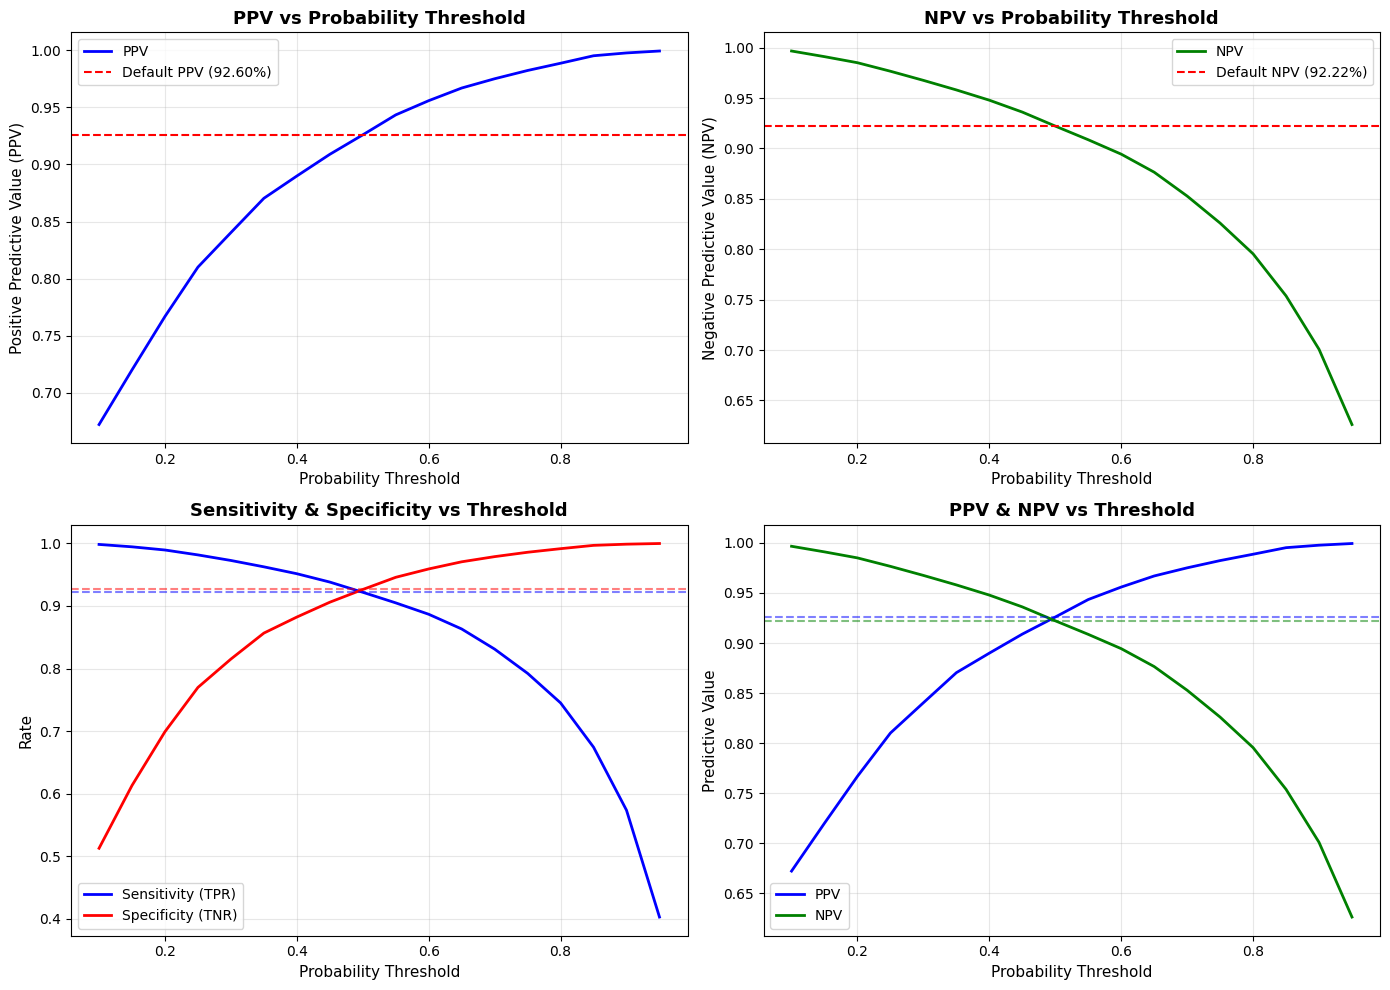

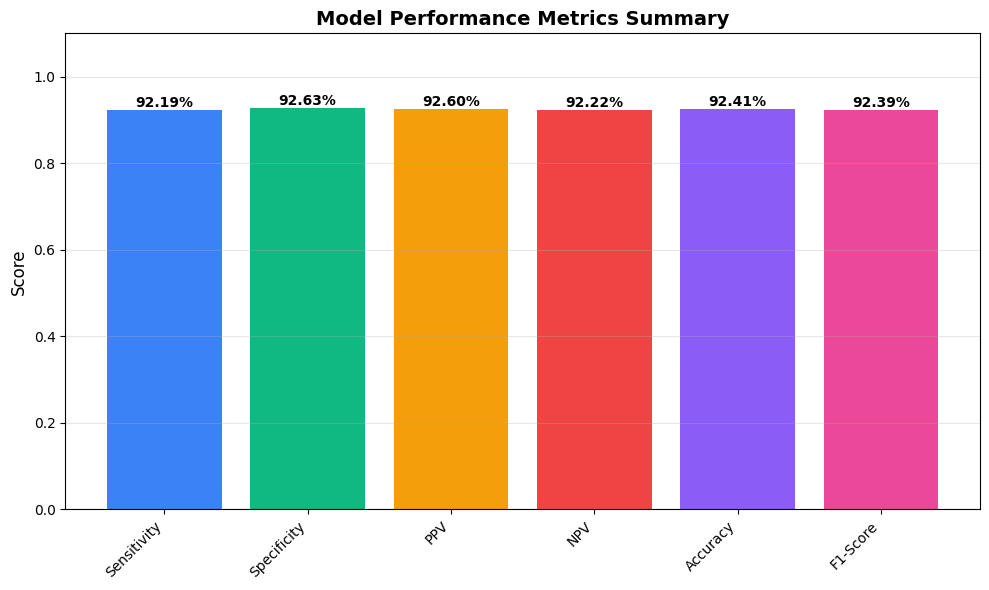

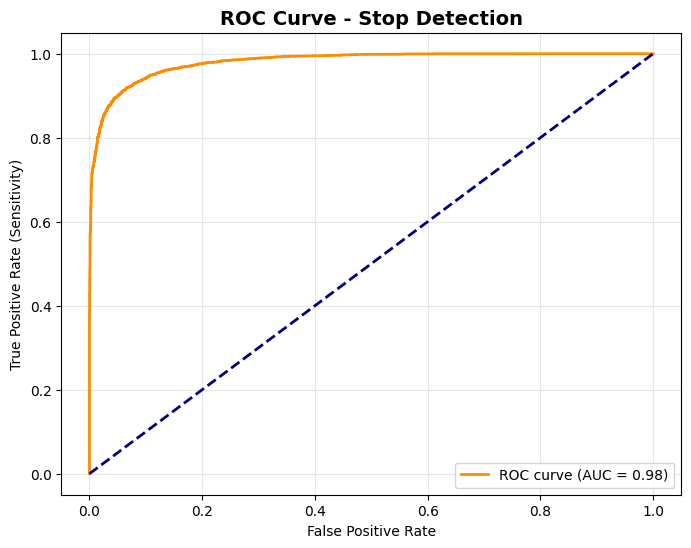

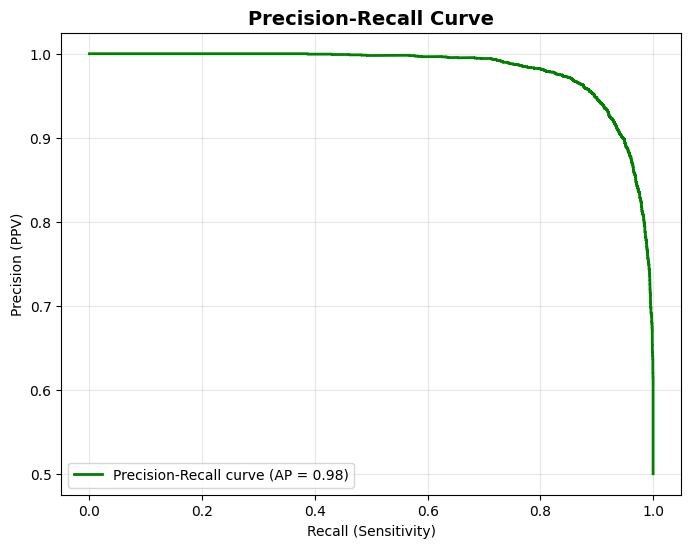

In [11]:
print("PPV and NPV Analysis")

#calculate PPV and NPV at different probability thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
ppv_values = []
npv_values = []
sensitivity_values = []
specificity_values = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_prob >= threshold).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)

    tn, fp, fn, tp = cm_thresh.ravel()

    #calculate metrics
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv_val = tn / (tn + fn) if (tn + fn) > 0 else 0

    sensitivity_values.append(sens)
    specificity_values.append(spec)
    ppv_values.append(ppv_val)
    npv_values.append(npv_val)

#Plot PPV and NPV vs Threshold
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#PPV vs Threshold
axes[0, 0].plot(thresholds, ppv_values, 'b-', linewidth=2, label='PPV')
axes[0, 0].axhline(y=ppv, color='r', linestyle='--', label=f'Default PPV ({ppv:.2%})')
axes[0, 0].set_xlabel('Probability Threshold', fontsize=11)
axes[0, 0].set_ylabel('Positive Predictive Value (PPV)', fontsize=11)
axes[0, 0].set_title('PPV vs Probability Threshold', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

#NPV vs Threshold
axes[0, 1].plot(thresholds, npv_values, 'g-', linewidth=2, label='NPV')
axes[0, 1].axhline(y=npv, color='r', linestyle='--', label=f'Default NPV ({npv:.2%})')
axes[0, 1].set_xlabel('Probability Threshold', fontsize=11)
axes[0, 1].set_ylabel('Negative Predictive Value (NPV)', fontsize=11)
axes[0, 1].set_title('NPV vs Probability Threshold', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

#Sensitivity and Specificity vs Threshold
axes[1, 0].plot(thresholds, sensitivity_values, 'b-', linewidth=2, label='Sensitivity (TPR)')
axes[1, 0].plot(thresholds, specificity_values, 'r-', linewidth=2, label='Specificity (TNR)')
axes[1, 0].axhline(y=sensitivity, color='b', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=specificity, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Probability Threshold', fontsize=11)
axes[1, 0].set_ylabel('Rate', fontsize=11)
axes[1, 0].set_title('Sensitivity & Specificity vs Threshold', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

#PPV and NPV Combined
axes[1, 1].plot(thresholds, ppv_values, 'b-', linewidth=2, label='PPV')
axes[1, 1].plot(thresholds, npv_values, 'g-', linewidth=2, label='NPV')
axes[1, 1].axhline(y=ppv, color='b', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=npv, color='g', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Probability Threshold', fontsize=11)
axes[1, 1].set_ylabel('Predictive Value', fontsize=11)
axes[1, 1].set_title('PPV & NPV vs Threshold', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

#metrics bar chart
metrics_dict = {
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'PPV': ppv,
    'NPV': npv,
    'Accuracy': accuracy,
    'F1-Score': f1
}

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_dict.keys(), metrics_dict.values(),
               color=['#3b82f6', '#10b981', '#f59e0b', '#ef4444', '#8b5cf6', '#ec4899'])
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Metrics Summary', fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)

#add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Stop Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

#Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, color='green', lw=2,
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

## **Feature Importance Analysis**

Feature Importance Analysis

Top 10 Most Important Features:
          feature  importance
0             lat    0.203115
1             lng    0.137145
2       speed_mps    0.127332
12      speed_kmh    0.105672
16  high_accuracy    0.046062
13        is_slow    0.043416
14     is_stopped    0.040551
3        accuracy    0.040529
6              az    0.037247
7              gx    0.032761


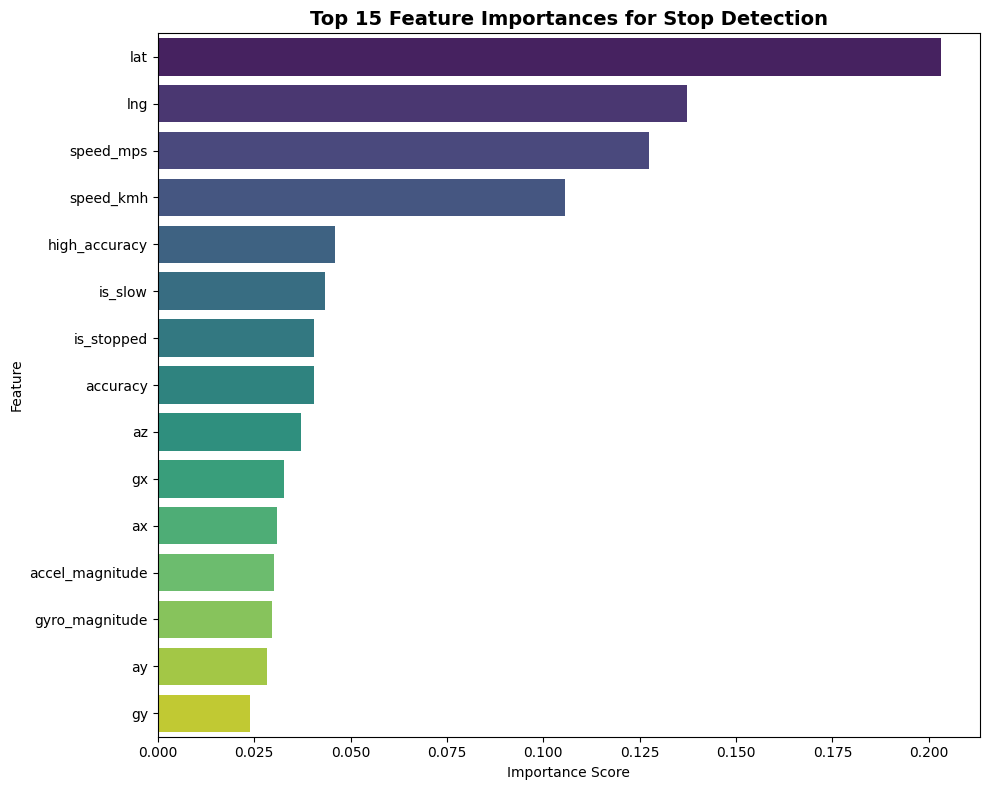

In [12]:
print("Feature Importance Analysis")

#fet feature importance from XGBoost
importance_df = pd.DataFrame({
    'feature': FINAL_FEATURES,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

#visualize
plt.figure(figsize=(10,8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importances for Stop Detection', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()




## **Export Models**

In [14]:
print("Exporting Model")

#model filename
MODEL_FILENAME = "TransitLK_ETA_Stop_Detection_XGB.pkl"

#save the trained model
joblib.dump(model, MODEL_FILENAME)

#save metadata
metadata = {
    'model_name': 'TransitLK ETA Stop Detection v1',
    'features': FINAL_FEATURES,
    'detection_radius_meters': DETECTION_RADIUS,
    'threshold': 0.5,
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'training_date': datetime.now().strftime('%Y-%m-%d'),
    'key_stops_r2b': KEY_STOPS_R2B,
    'key_stops_b2r': KEY_STOPS_B2R,
    'route_detection': 'Automatic based on latitude trend'
}

import json
with open('eta_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nModel saved: {MODEL_FILENAME}")
print(f"Metadata saved: eta_model_metadata.json")


print("\nFINAL FEATURE ORDER for Android Implementation:")
for i, feat in enumerate(FINAL_FEATURES, 1):
    print(f"  {i:2d}. {feat}")

print("\nModel Summary:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-Score: {f1:.2%}")
print(f"Detection Radius: {DETECTION_RADIUS}m")
print(f"Key Stops (R2B): {len(KEY_STOPS_R2B)}")
print(f"Key Stops (B2R): {len(KEY_STOPS_B2R)}")

#save stop coordinates for Android
stops_data = {
    'ratmalana_to_bambalapitiya': {k: {'lat': v[0], 'lng': v[1]}
                                    for k, v in STOPS_RATMALANA_TO_BAMBALAPITIYA.items()},
    'bambalapitiya_to_ratmalana': {k: {'lat': v[0], 'lng': v[1]}
                                    for k, v in STOPS_BAMBALAPITIYA_TO_RATMALANA.items()}
}

with open('bus_stops.json', 'w') as f:
    json.dump(stops_data, f, indent=2)

print(f"Bus stops saved: bus_stops.json")

#download files
files.download(MODEL_FILENAME)
files.download('eta_model_metadata.json')
files.download('bus_stops.json')

print("\nAll files ready for download!")
print("ETA Model Training Complete!")

Exporting Model

Model saved: TransitLK_ETA_Stop_Detection_XGB.pkl
Metadata saved: eta_model_metadata.json

FINAL FEATURE ORDER for Android Implementation:
   1. lat
   2. lng
   3. speed_mps
   4. accuracy
   5. ax
   6. ay
   7. az
   8. gx
   9. gy
  10. gz
  11. accel_magnitude
  12. gyro_magnitude
  13. speed_kmh
  14. is_slow
  15. is_stopped
  16. accel_jerk
  17. high_accuracy

Model Summary:
Accuracy: 92.41%
Precision: 92.60%
Recall: 92.19%
F1-Score: 92.39%
Detection Radius: 50m
Key Stops (R2B): 16
Key Stops (B2R): 16
Bus stops saved: bus_stops.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All files ready for download!
ETA Model Training Complete!
